In [1]:
import pydicom
from pathlib import Path
import re

loc = '/run/media/anton/Elements/UKB/20204/Bulk/Liver MRI/ShMOLLI/10/'
subs = []

for ent in Path(loc).iterdir():
    if not ent.is_dir():
        continue
    mtch = re.match('(\\d+)_20204_2_0', ent.name)
    if mtch:
        subs.append(mtch.group(1))

print(len(subs))

1659


In [29]:
sub_dcms = dict()

for i,sub in enumerate(subs):
    dcm_paths = []
    for ent in Path(f'{loc}/{sub}_20204_2_0').iterdir():
        if re.match('.*\\.dcm$', ent.name):
            dcm_paths.append(ent)
            
    dcms = []
    for path in dcm_paths:
        d = pydicom.dcmread(path)
        dcms.append(d)

    series_numbers = set()
    for dcm in dcms:
        series_numbers.add(int(dcm.SeriesNumber))
    series_numbers = sorted(list(series_numbers))

    first_dcms = []
    for dcm in dcms:
        if int(dcm.SeriesNumber) == series_numbers[0]:
            first_dcms.append(dcm)

    #first_dcms.sort(key=lambda dcm: int(dcm.InstanceNumber))
    first_dcms.sort(key=lambda dcm: int(dcm.ImageComments.split(' ')[1]))

    for dcm in first_dcms:
        print(dcm.InstanceNumber, dcm.ImageComments)

    sub_dcms[sub] = first_dcms

    # sub_dcms[sub] = []
    # for dcm in dcms:
    #     if int(dcm.SeriesNumber) == series_numbers[0]: # and int(dcm.InstanceNumber) == 1:
    #         sub_dcms[sub].append(dcm) #dcm.pixel_array

    # for dcm in sub_dcms[sub]:
    #     print(dcm.ImageComments)

    break

1 TIeff 170 ms
6 TIeff 220 ms
7 TIeff 270 ms
2 TIeff 1115 ms
3 TIeff 2060 ms
4 TIeff 3002 ms
5 TIeff 3945 ms


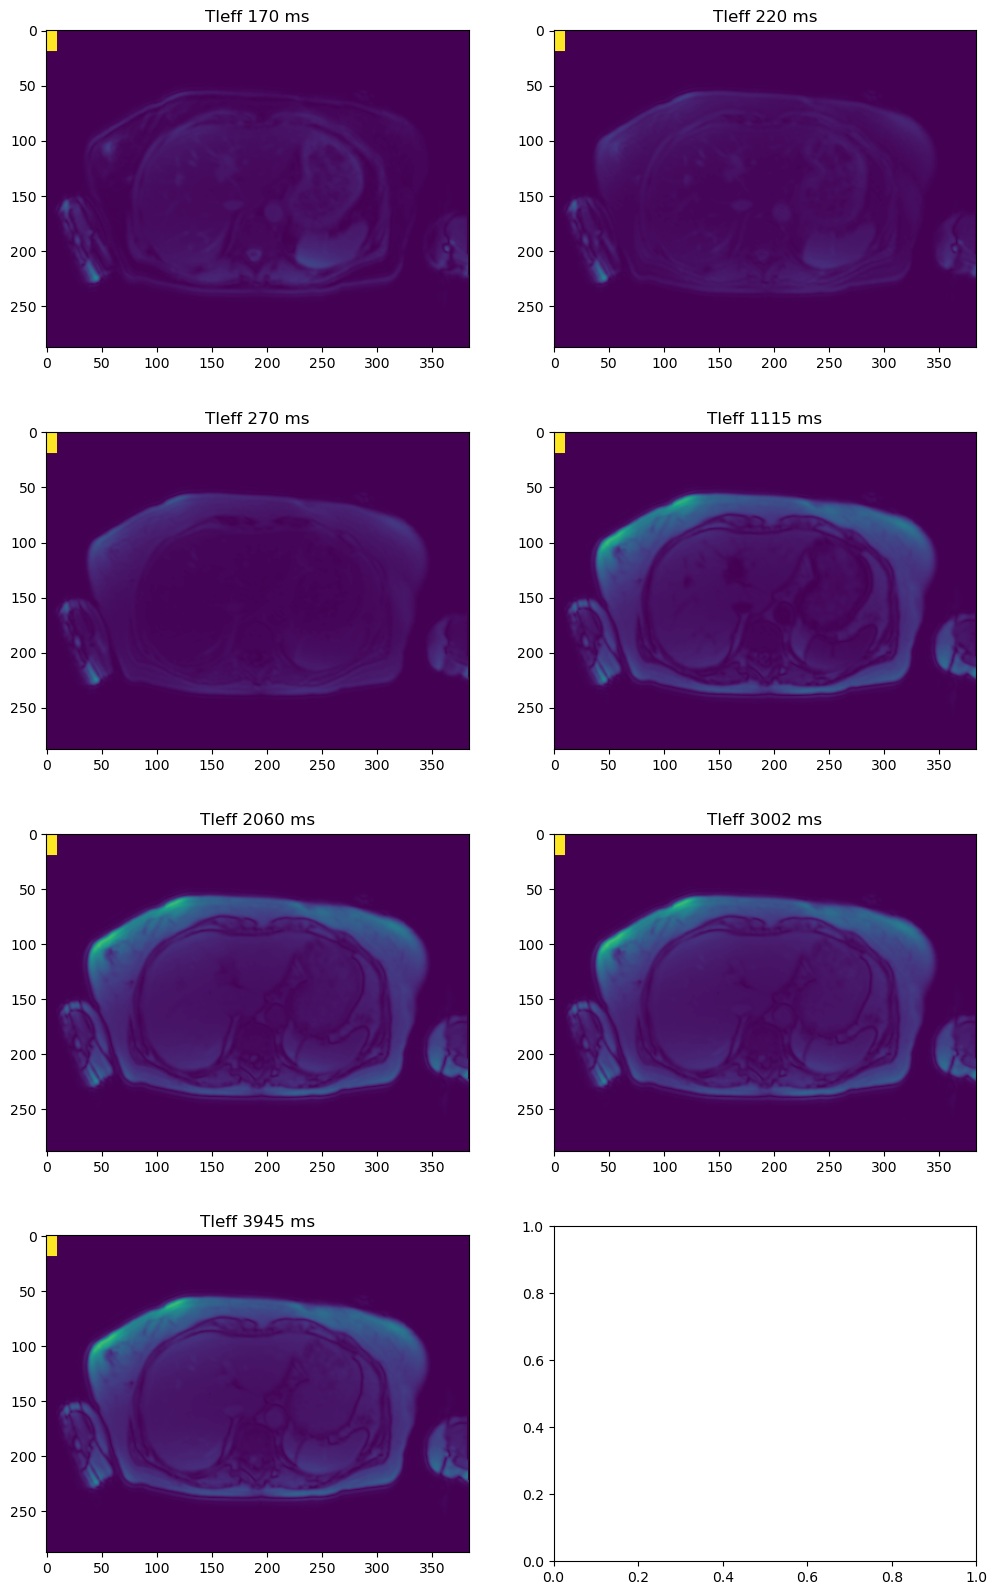

In [35]:
import matplotlib.pyplot as plt
import math 

fig, ax = plt.subplots(4,2,figsize=(12,20))

for sub in sub_dcms:
    dcms = sub_dcms[sub]
    for i,dcm in enumerate(dcms):
        r = math.floor(i/2)
        c = i%2
        # dcm.pixel_array[:20,:10] = 1000
        ax[r,c].imshow(dcm.pixel_array)
        ax[r,c].set_title(dcm.ImageComments)
    
    break

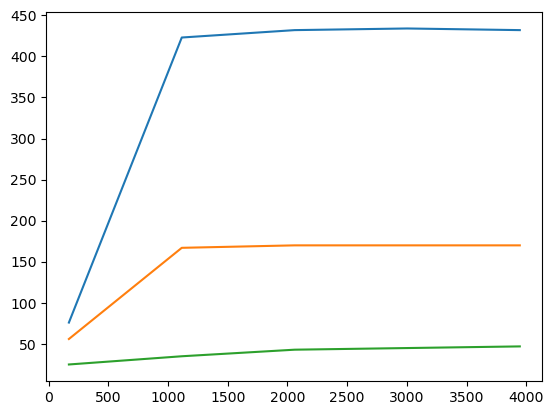

In [62]:
pixels = [(100, 60), (100,100), (150, 150)]
series = [[], [], []]
times = []

for sub in sub_dcms:
    dcms = sub_dcms[sub]
    for j,dcm in enumerate(dcms):
        if j == 1 or j == 2:
            continue
        times.append(int(dcm.ImageComments.split(' ')[1]))
        for i,px in enumerate(pixels):
            val = dcm.pixel_array[px[0], px[1]]
            series[i].append(val)

    plt.plot(times, series[0])
    plt.plot(times, series[1])
    plt.plot(times, series[2])
    
    break

In [63]:
import torch
import numpy as np

x = []
for sub in sub_dcms:
    dcms = sub_dcms[sub]
    for j,dcm in enumerate(dcms):
        if j == 1 or j == 2:
            continue
        x.append(torch.from_numpy(dcm.pixel_array).float().cuda())

x = torch.stack(x)
t = torch.from_numpy(np.array(times)).float().cuda()

A = torch.randn(*x.shape[1:]).float().cuda()
B = torch.randn(*x.shape[1:]).float().cuda()
T1 = 100*torch.ones(*x.shape[1:]).float().cuda()

for z in [A, B, T1]:
    z.requires_grad_(True)
    z.retain_grad()

optim = torch.optim.Adam([A, B, T1], lr=1e0)

nepochs = 2000
pperiod = 100

for e in range(nepochs):
    optim.zero_grad()
    arg = torch.einsum('t,xy->txy',t,-1/T1)
    val = torch.exp(arg)
    val = A.unsqueeze(0) - B.unsqueeze(0)*val
    loss = torch.sum((val-x)**2)**0.5
    loss.backward()
    optim.step()
    if e % pperiod == 0 or e == nepochs-1:
        print(f'{e} {float(loss)}')

0 75426.859375
100 50652.43359375
200 34968.8125
300 24292.884765625
400 16946.142578125
500 11928.3212890625
600 8930.1328125
700 7091.69482421875
800 5741.11962890625
900 4757.39990234375
1000 4132.5322265625
1100 3807.2431640625
1200 3666.464599609375
1300 3610.453125
1400 3586.428955078125
1500 3573.262939453125
1600 3563.880615234375
1700 3556.317138671875
1800 3549.83544921875
1900 3544.128662109375
1999 3539.155517578125


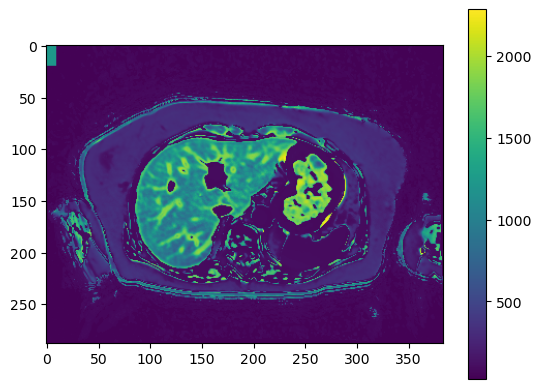

In [73]:
t1 = T1.detach().cpu().numpy()

plt.imshow(t1)
plt.colorbar()

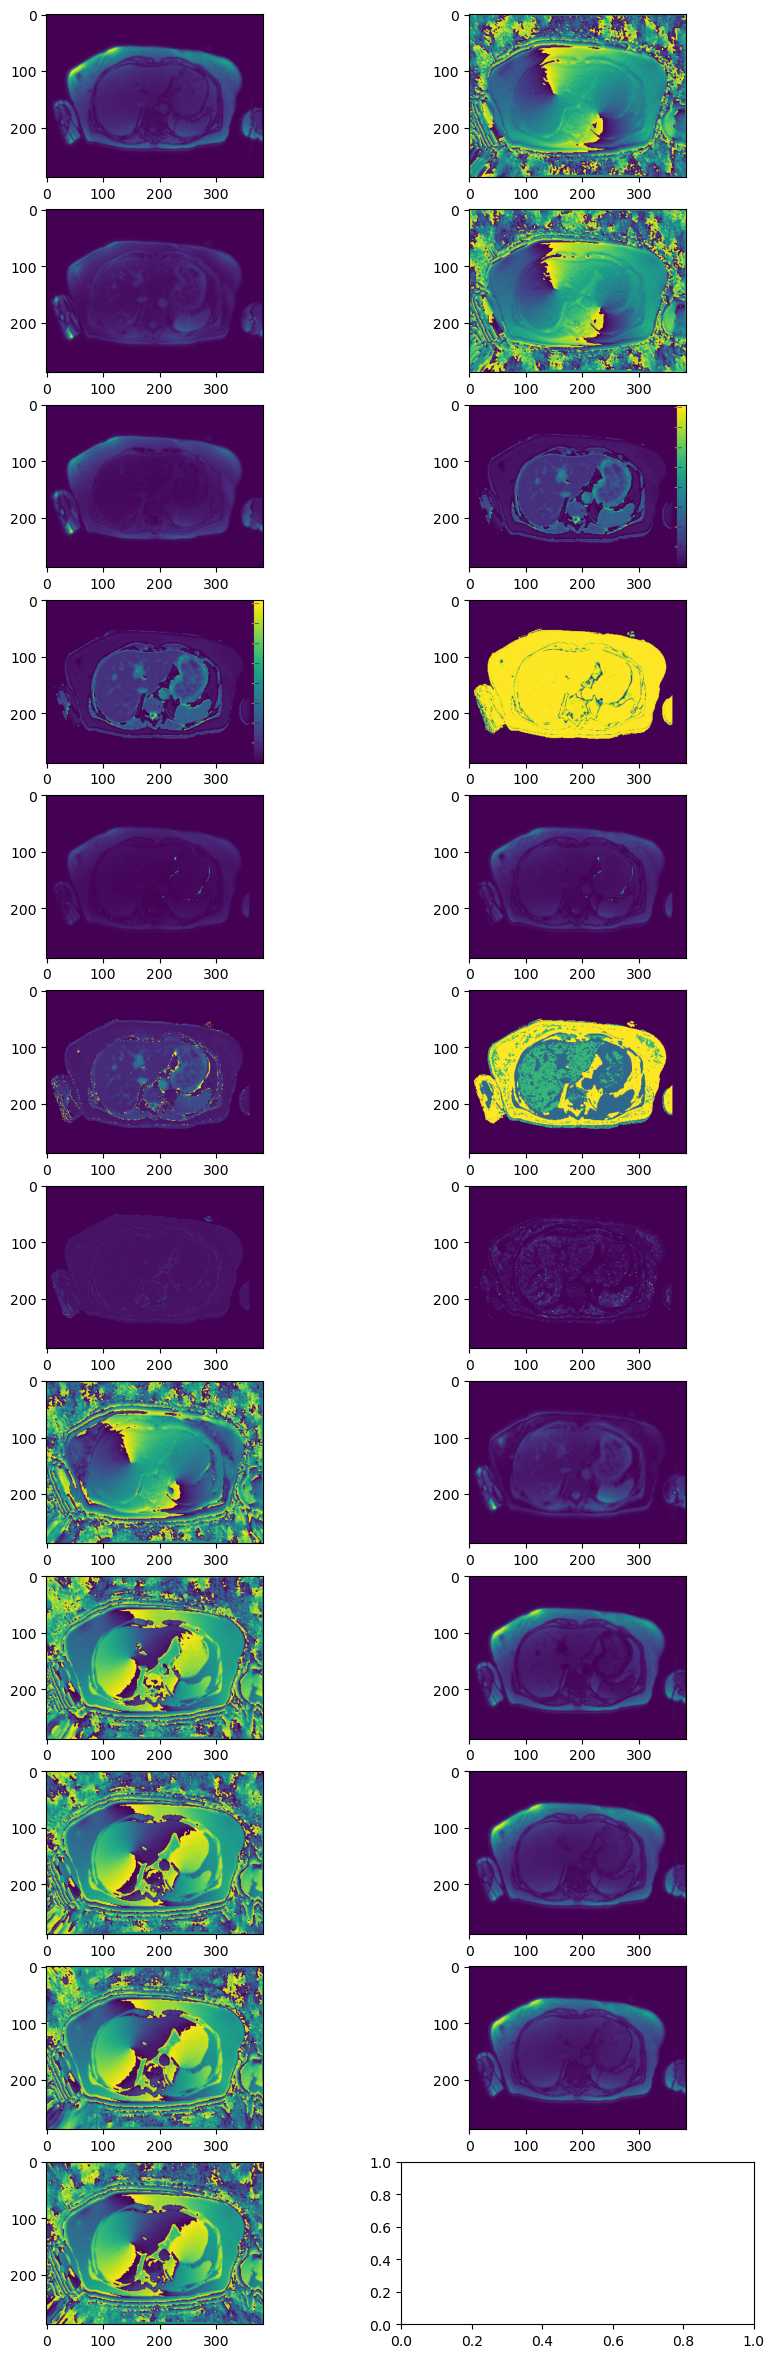

In [81]:
# Check if we already have a T1-like in the original DICOM images
# Conclusion: it looks like we don't

for i,sub in enumerate(subs):
    dcm_paths = []
    for ent in Path(f'{loc}/{sub}_20204_2_0').iterdir():
        if re.match('.*\\.dcm$', ent.name):
            dcm_paths.append(ent)
            
    dcms = []
    for path in dcm_paths:
        d = pydicom.dcmread(path)
        dcms.append(d)

    break

N = len(dcms)

fig, ax = plt.subplots(math.ceil(N/2),2,figsize=(10,30))

for i,dcm in enumerate(dcms):
    r = math.floor(i/2)
    c = i%2
    ax[r,c].imshow(dcm.pixel_array)